# Pandas part 3: Grouping data and merging tables

Notebook developed by Sam Maurer

In [1]:
import pandas as pd

## 1. Loading the data

In this demo we'll use a set of data about buildings and households in San Francisco. It's in [HDF format](https://en.wikipedia.org/wiki/Hierarchical_Data_Format), which is a way of storing data on disk that similar to a database.

I'm having trouble loading this data directly from a URL, so instead we'll have Python download the file and save it into the same folder as this notebook.

In [2]:
url = 'https://github.com/urbansim/urbansim_parcels/raw/master/sf_example/data/sanfran_public.h5'

In [3]:
import requests  #  third-party library for making HTTP requests
r = requests.get(url)  # gets everything (data + metadata) that a web browser would
open('sanfran_public.h5', 'wb').write(r.content)  # saves content to disk

39633731

An HDF file can contain more than one table. Let's see what they are:

In [4]:
hdf = pd.HDFStore('sanfran_public.h5')
print(hdf.keys())
hdf.close()

['/buildings', '/households', '/jobs', '/parcels', '/zones', '/zoning', '/zoning_for_parcels']


We can load these tables as DataFrames one at a time.

### New function -- `pd.read_hdf()`, documentation [here](https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.read_hdf.html)
- arguments: a filename or URL, and the name of a table inside the file
- returns: a DataFrame

In [5]:
buildings = pd.read_hdf('sanfran_public.h5', 'buildings')

In [6]:
buildings.head()

,parcel_id,residential_units,non_residential_sqft,building_sqft,stories,building_type_id,year_built,residential_sales_price,non_residential_rent
building_id,,,,,,,,,
66515,69377,3.0,0.0,4755.0,3.0,3.0,1900.0,568.475987,NaN
123898,131763,2.0,0.0,3770.0,2.0,3.0,1923.0,334.338944,NaN
44682,46013,1.0,0.0,2275.0,1.0,2.0,1931.0,425.759660,NaN
62974,65342,3.0,0.0,4032.0,3.0,3.0,1910.0,595.244178,NaN
55586,57438,1.0,0.0,1225.0,1.0,2.0,1927.0,550.923428,NaN


Some things to notice:

1. Unlike when we read a CSV, the DataFrame's index now has a **name**. And its values are **not sequential**. This was set up before the data was saved, and the HDF format preserves it.

  DataFrame indexes are different from normal columns. In some ways you can treat them like regular data, but often not. To remove the index's special properties, you can copy the values into a separate column, or run `.reset_index()` on the DataFrame.
  
  
  
2. Does anything strike you about the data values in the table?

### Review

Try using `.describe()` to get some descriptive statistics about the buildings.

Then use `.plot.hist()` to make histograms of some of the variables.

Remember that you can filter data using `.loc[<expression>]` to make the histogram clearer!

In [7]:
buildings.describe()

,parcel_id,residential_units,non_residential_sqft,building_sqft,stories,building_type_id,year_built,residential_sales_price,non_residential_rent
count,152605.000000,152605.000000,1.512640e+05,1.526050e+05,152605.000000,152603.000000,149488.000000,138407.000000,10203.000000
mean,76969.132243,2.451656,1.935699e+03,4.823261e+03,1.680993,2.938782,1932.577759,543.022467,24.011638
std,44534.894685,8.918821,2.602301e+04,3.464895e+04,1.345603,2.241784,50.238934,171.802835,7.224345
min,1.000000,1.000000,0.000000e+00,1.000000e+00,1.000000,1.000000,1791.000000,14.502545,10.488493
25%,38310.000000,1.000000,0.000000e+00,1.250000e+03,1.000000,2.000000,1911.000000,460.778445,23.136462
50%,76725.000000,1.000000,0.000000e+00,1.749000e+03,1.000000,2.000000,1927.000000,528.836079,26.263879
75%,115865.000000,2.000000,0.000000e+00,2.950000e+03,2.000000,3.000000,1947.000000,596.269347,28.758149
max,154629.000000,300.000000,3.258029e+06,4.701100e+06,60.000000,14.000000,8687.000000,10138.582062,40.735691


In [8]:
# Run this cell to get rid of the scientific notation

pd.options.display.float_format = '{:20,.2f}'.format

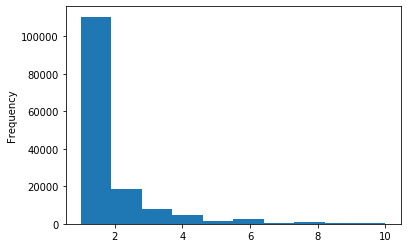

In [9]:
sample_buildings = buildings.loc[buildings.residential_units <= 10]

sample_buildings.residential_units.plot.hist()

## 2. Grouping data

Often you'll want to divide your data into categories while analyzing it. You can always do this manually with filter expressions, but Pandas also has tools to do it automatically.

<img src='https://raw.githubusercontent.com/waddell/CP255/master/05-data-manipulation/img/groupby.png' height="800" width="500">

### New function -- `.groupby()`, documentation [here](https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.DataFrame.groupby.html)
- call from: a DataFrame
- arguments: name of a column representing groups
- returns: a special "grouped" DataFrame

In [10]:
buildings.loc[buildings.stories<7].groupby('stories').residential_units.describe()

,count,mean,std,min,25%,50%,75%,max
stories,,,,,,,,
1.00,"81,111.00",1.20,4.00,1.00,1.00,1.00,1.00,300.00
2.00,"52,321.00",2.31,6.64,1.00,1.00,1.00,2.00,300.00
3.00,"14,928.00",5.44,10.69,1.00,1.00,3.00,6.00,300.00
4.00,"2,431.00",11.57,20.25,1.00,1.00,6.00,14.00,300.00
5.00,548.00,21.59,33.09,1.00,1.00,9.50,29.00,268.00
6.00,480.00,24.48,33.72,1.00,1.00,15.00,38.00,300.00


Let's review that syntax piece by piece:

- `buildings` --> a DataFrame
- `buildings.loc[buildings.stories<7]` --> only rows with <7 stories
- `.groupby('stories')` --> divide the data into groups for further analysis
- `.residential_units` --> focus on a single column
- `.describe()` --> descriptive statistics broken down by group

### Exercise

What years were buildings of different heights constructed? All you need to do is replace one of the column names from the previous line of code.

In [11]:
buildings.loc[buildings.stories<7].groupby('stories').year_built.describe()

,count,mean,std,min,25%,50%,75%,max
stories,,,,,,,,
1.00,"79,173.00","1,936.10",28.39,"1,791.00","1,924.00","1,938.00","1,948.00","5,953.00"
2.00,"51,350.00","1,929.00",58.39,"1,800.00","1,907.00","1,921.00","1,946.00","8,583.00"
3.00,"14,827.00","1,924.08",34.97,"1,850.00","1,906.00","1,911.00","1,928.00","4,101.00"
4.00,"2,381.00","1,934.05",34.61,"1,875.00","1,908.00","1,917.00","1,962.00","2,011.00"
5.00,533.00,"1,934.97",34.17,"1,900.00","1,910.00","1,918.00","1,963.00","2,009.00"
6.00,474.00,"1,928.74",25.06,"1,900.00","1,912.00","1,923.00","1,929.00","2,010.00"


Now, use this line of code to add a column listing the decade of construction: 

`buildings['decade'] = (buildings.loc[buildings.year_built<2010].year_built//10)*10`

Re-group the data using the new variable. What can you learn about what's been built over time?

In [12]:
buildings['decade'] = (buildings.loc[buildings.year_built<2010].year_built//10)*10

In [13]:
buildings.groupby('decade').stories.describe()

,count,mean,std,min,25%,50%,75%,max
decade,,,,,,,,
"1,790.00",1.00,1.00,nan,1.00,1.00,1.00,1.00,1.00
"1,800.00",1.00,2.00,nan,2.00,2.00,2.00,2.00,2.00
"1,840.00",2.00,2.00,0.00,2.00,2.00,2.00,2.00,2.00
"1,850.00",8.00,2.62,0.52,2.00,2.00,3.00,3.00,3.00
"1,860.00",9.00,2.11,0.60,1.00,2.00,2.00,2.00,3.00
"1,870.00",90.00,2.03,0.76,1.00,2.00,2.00,2.00,4.00
"1,880.00",445.00,2.02,0.66,1.00,2.00,2.00,2.00,4.00
"1,890.00",897.00,2.01,1.05,1.00,2.00,2.00,2.00,22.00
"1,900.00","31,878.00",2.02,1.07,1.00,1.00,2.00,2.00,40.00


## 3. Merging data

Sometimes you'll want to merge information together from more than one DataFrame. This is a common operation when data is divided into multiple, relational tables like in a database.

The best way to start is to think about the hierarchy of the data tables you're working with. For example:

- multiple *households* go into a *building*
- multiple *buildings* go into a *census tract*
- multiple *census tracts* go into a *county*

The most common type of merge looks like this: For each row of data about the **finer-grained thing**, use an ID to look up information about the associated **coarser thing**, and add the information as new columns.

### New function -- `pd.merge()`, documentation [here](https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.merge.html)
- arguments: two source DataFrames, ids to use for joining, instructions on how to merge
- returns: a new DataFrame

### Loading more data: households

To try this out, we'll load a second table with data about households in San Francisco. Note that these are **not real households**! The data is what's called a "synthetic population", where individual households are created algorithmically to match the known demographic characteristics of each census tract. In aggregate, the association between people and buildings will be realistic, but the individual data points are fake.

In [14]:
households = pd.read_hdf('sanfran_public.h5', 'households')

In [15]:
households.head()

,building_id,building_type_id,income,persons,tenure
household_id,,,,,
1,136325,1,27310,1,2
4,133982,2,25000,1,2
5,25633,1,3100,1,1
6,132596,2,7200,1,1
7,57108,1,27310,1,2


### Merging coarse-to-fine (one-to-many)

Multiple **households** are in each **building**. And we see that each household has a `building_id` associated with it. 

This means that we're able to merge characteristics of the **buildings** directly onto the **households** table.

In [16]:
extended_households = pd.merge(households, buildings, on='building_id', how='left')

In [17]:
extended_households.head()

,building_id,building_type_id_x,income,persons,tenure,parcel_id,residential_units,non_residential_sqft,building_sqft,stories,building_type_id_y,year_built,residential_sales_price,non_residential_rent,decade
0,136325,1,27310,1,2,146921,1.00,0.00,"15,792.00",1.00,1.00,nan,nan,nan,nan
1,133982,2,25000,1,2,144193,1.00,0.00,"1,420.00",1.00,2.00,"1,922.00",602.64,nan,"1,920.00"
2,25633,1,3100,1,1,26421,1.00,0.00,"1,524.00",1.00,2.00,"1,948.00",470.22,nan,"1,940.00"
3,132596,2,7200,1,1,142643,1.00,0.00,"1,370.00",1.00,2.00,"1,907.00",627.89,nan,"1,900.00"
4,57108,1,27310,1,2,59019,1.00,0.00,"1,214.00",1.00,2.00,"1,945.00",516.36,nan,"1,940.00"


### Merging fine-to-coarse (many-to-one)

What if we want to bring information from the **households** table over to the **buildings** table? This is harder! 

Because there are multiple households in each building, we have to **summarize** the information first: calculate a sum, or a mean, or even just pick the first value.

But **`.groupby()`** can help us with this:

In [18]:
household_totals = households.groupby('building_id').median()

In [19]:
extended_buildings = pd.merge(buildings, household_totals, on='building_id', how='left')

In [20]:
extended_buildings.head()

,parcel_id,residential_units,non_residential_sqft,building_sqft,stories,building_type_id_x,year_built,residential_sales_price,non_residential_rent,decade,building_type_id_y,income,persons,tenure
building_id,,,,,,,,,,,,,,
66515,69377,3.00,0.00,"4,755.00",3.00,3.00,"1,900.00",568.48,nan,"1,900.00",3.00,"60,500.00",2.00,1.00
123898,131763,2.00,0.00,"3,770.00",2.00,3.00,"1,923.00",334.34,nan,"1,920.00",3.00,"83,000.00",2.00,1.00
44682,46013,1.00,0.00,"2,275.00",1.00,2.00,"1,931.00",425.76,nan,"1,930.00",nan,nan,nan,nan
62974,65342,3.00,0.00,"4,032.00",3.00,3.00,"1,910.00",595.24,nan,"1,910.00",3.00,"69,000.00",2.00,2.00
55586,57438,1.00,0.00,"1,225.00",1.00,2.00,"1,927.00",550.92,nan,"1,920.00",2.00,"19,070.00",1.00,2.00


### Exercise!

What can you learn from the merged data? Here are some things you might look at:

- How do people's incomes vary by housing tenure? ("Tenure" means rent/own in this context.) Can you use this to guess which tenure category is which?
  

- How does the tenure split vary by decade of construction?
  

- Do higher-income households tend to live in larger buildings or in smaller buildings?
  

- What's the total population in single-family homes vs. multi-unit buildings? (You'll need to summarize the households with `.sum()` to count the people.)
  

- How has the square footage of units changed over time?

In [21]:
# How do incomes vary by housing tenure?

relevant_data = households[['income','tenure']]

relevant_data.groupby('tenure').describe()

income                                            \
                      count                 mean                  std   
tenure                                                                  
1                221,942.00            65,615.76            70,748.39   
2                123,646.00           110,510.98            98,307.75   

                                                                       \
                        min                  25%                  50%   
tenure                                                                  
1                -10,000.00            21,000.00            47,000.00   
2                -10,000.00            48,700.00            84,020.00   

                                                  
                        75%                  max  
tenure                                            
1                 84,000.00           948,000.00  
2                138,000.00         1,237,000.00

In [22]:
# How has the tenure split of buildings changed over time? There is surely 
# a more elegant way to do this, but here's one approach:

rental_buildings = extended_buildings.loc[extended_buildings.tenure == 1]
owned_buildings = extended_buildings.loc[extended_buildings.tenure == 2]

rental_counts = rental_buildings.groupby('decade').tenure.count()  # -> Series
owned_counts = owned_buildings.groupby('decade').tenure.count()  # -> Series

rental_counts/owned_counts  # divide one Series by the other

decade
1,800.00                    nan
1,850.00                   1.00
1,860.00                   4.00
1,870.00                   2.68
1,880.00                   2.34
1,890.00                   1.94
1,900.00                   1.68
1,910.00                   1.24
1,920.00                   0.86
1,930.00                   0.55
1,940.00                   0.55
1,950.00                   0.62
1,960.00                   1.17
1,970.00                   1.19
1,980.00                   1.50
1,990.00                   1.34
2,000.00                   1.69
Name: tenure, dtype: float64

In [23]:
# Do higher-income housholds live in larger buildings or smaller buildings?

relevant_data = extended_buildings.loc[extended_buildings.stories < 7, 
                                       ['stories', 'income']]

relevant_data.groupby('stories').income.describe()

,count,mean,std,min,25%,50%,75%,max
stories,,,,,,,,
1.00,"57,158.00","92,527.32","74,260.15","-10,000.00","46,200.00","76,262.50","116,000.00","855,500.00"
2.00,"42,214.00","73,588.39","67,314.62","-4,200.00","32,700.00","57,275.00","91,446.25","881,980.00"
3.00,"12,099.00","70,140.99","59,589.79",0.00,"32,000.00","57,800.00","90,662.50","733,000.00"
4.00,"1,721.00","67,433.46","55,709.81",0.00,"28,500.00","56,000.00","94,000.00","650,000.00"
5.00,319.00,"49,886.90","43,323.16",0.00,"16,462.50","37,000.00","65,400.00","303,800.00"
6.00,282.00,"53,985.06","44,518.33",700.00,"16,000.00","38,700.00","84,975.00","186,900.00"


In [24]:
# What's the total population in single-family homes vs. multi-unit buildings?

household_sums = households.groupby('building_id').sum()

extended_buildings_2 = pd.merge(buildings, household_sums, on='building_id', how='left')

total = extended_buildings_2.persons.sum()  # -> single value
singlefam = extended_buildings_2.loc[extended_buildings_2.residential_units == 1].persons.sum()

print("single-family =", singlefam)
print("multi-family =", total-singlefam)

single-family = 340463.0
multi-family = 439879.0


In [25]:
# How has square footage of units changed over time?

buildings.groupby('decade').building_sqft.describe()

,count,mean,std,min,25%,50%,75%,max
decade,,,,,,,,
"1,790.00",1.00,"1,791.00",nan,"1,791.00","1,791.00","1,791.00","1,791.00","1,791.00"
"1,800.00",1.00,"4,875.00",nan,"4,875.00","4,875.00","4,875.00","4,875.00","4,875.00"
"1,840.00",2.00,"2,148.00",639.22,"1,696.00","1,922.00","2,148.00","2,374.00","2,600.00"
"1,850.00",8.00,"7,834.00","8,088.58","2,390.00","2,939.00","4,425.00","8,657.00","26,150.00"
"1,860.00",9.00,"10,605.00","18,794.10","2,084.00","2,375.00","2,762.00","5,250.00","59,786.00"
"1,870.00",90.00,"3,613.81","3,428.99",594.00,"1,556.00","2,320.50","3,955.75","17,600.00"
"1,880.00",445.00,"2,871.36","3,198.76",412.00,"1,500.00","2,184.00","3,060.00","44,484.00"
"1,890.00",897.00,"3,684.50","15,997.12",434.00,"1,445.00","2,216.00","3,410.00","439,232.00"
"1,900.00","31,878.00","4,617.91","21,940.23",1.00,"1,387.25","2,280.00","3,668.00","1,545,363.00"
